In [1]:
import os

In [2]:
os.chdir('../ease')

In [3]:
from ease.feature_extractor import FeatureExtractor

In [13]:
feature_extractor = FeatureExtractor()

In [5]:
from ease.essay_set import EssaySet

In [6]:
essay_set = EssaySet()

In [7]:
import pandas as pd

X = pd.read_csv('../essaysense/essaysense/datasets/training_set_rel3.tsv', sep='\t', encoding='ISO-8859-1')
y = X['domain1_score']

In [8]:
X = X[['essay_set', 'essay']]

In [9]:
X.iloc[0]['essay']

"Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How would you feel if your teenager is always on the phone with friends! Do you ever time to chat with your friends or buisness partner about things. Well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: @ORGANIZATION1, @ORGANIZATION2, @CAPS1, facebook, myspace ect. Just think now while your setting up meeting with your boss on the computer, your teenager is having fun on the phone not rushing to get off cause you want to use it. How did you learn about other countrys/states outside of yours? Well I have by computer/internet, it's a new way to learn about what going on in our time! You might think your child spends a lot of time on the computer, but ask them so question about the econom

In [10]:
X.head()

,essay_set,essay
0,1,"Dear local newspaper, I think effects computer..."
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu..."
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl..."
3,1,"Dear Local Newspaper, @CAPS1 I have found that..."
4,1,"Dear @LOCATION1, I know having computers has a..."


In [11]:
from tqdm import tqdm

In [12]:
for i in tqdm(range(len(X.index))):
    essay_set.add_essay(X.iloc[i]['essay'], int(y.iloc[i]))

100%|██████████| 12976/12976 [07:57<00:00, 18.89it/s]


In [17]:
import numpy as np

In [14]:
ok = np.ones(100)

In [29]:
neg = 0
for i in tqdm(X.index[:100]):
    try:
        essay_set.add_essay(X.loc[i]['essay'], int(y.iloc[i]))
    except:
        ok[neg] = 0
    neg += 1

100%|██████████| 100/100 [00:07<00:00, 12.64it/s]


In [30]:
ok.mean()

0.82

In [31]:
essay_set = EssaySet()

In [41]:
import nltk

In [17]:
essay_set.add_essay(X.iloc[0]['essay'], int(y.iloc[0]))

In [18]:
# import nltk
# nltk.download('averaged_perceptron_tagger')

In [14]:
feature_extractor.initialize_dictionaries(essay_set)

'ok'

In [ ]:
essay_set

In [15]:
features = feature_extractor.gen_feats(essay_set)

In [16]:
features.shape

(12976, 415)

In [19]:
np.save('ease_features.npy', features)

In [21]:
from sklearn.model_selection import train_test_split

In [44]:
x_train, x_test, y_train, y_test, essay_set_train, essay_set_test = \
        train_test_split(features, np.array(y, dtype=int), np.array(X['essay_set'], dtype=int), test_size=0.2)

In [45]:
score_range_min = np.array([2, 1, 0, 0, 0, 0, 0, 0])
score_range_max = np.array([12, 6, 3, 3, 4, 4, 30, 60])

In [58]:
def shrink(scores, essay_set):
    mini = np.choose(essay_set-1,score_range_min)
    maxi = np.choose(essay_set-1,score_range_max)
    
    return (scores - mini) / (maxi - mini)

def expand(scores, essay_set):
    mini = np.choose(essay_set-1,score_range_min)
    maxi = np.choose(essay_set-1,score_range_max)
    
    return np.array(np.round(scores * (maxi - mini) + mini),dtype=int)

In [48]:
from matplotlib import pyplot as plt
%matplotlib inline

(array([3719., 4493., 1603., 1344.,  852.,  457.,  211.,  190.,  102.,
           5.]),
 array([   4. ,  120.6,  237.2,  353.8,  470.4,  587. ,  703.6,  820.2,
         936.8, 1053.4, 1170. ]),
 <a list of 10 Patch objects>)

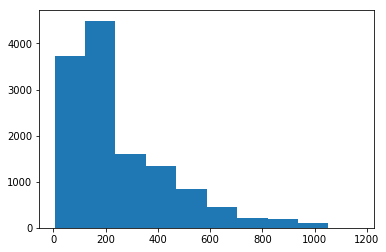

In [53]:
plt.hist(features[:,1])

In [50]:
from sklearn.preprocessing import StandardScaler

In [51]:
scaler = StandardScaler()

In [52]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

(array([2992., 3615., 1261., 1067.,  686.,  344.,  172.,  152.,   87.,
           4.]),
 array([-1.23959822, -0.64970725, -0.05981629,  0.53007467,  1.11996563,
         1.70985659,  2.29974755,  2.88963852,  3.47952948,  4.06942044,
         4.6593114 ]),
 <a list of 10 Patch objects>)

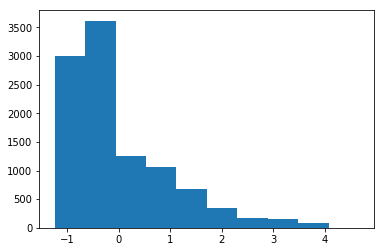

In [54]:
plt.hist(x_train[:,1])

In [55]:
y_train = shrink(y_train, essay_set_train)

In [56]:
y_test = shrink(y_test, essay_set_test)

In [59]:
from sklearn.linear_model import Lasso

In [85]:
model = Lasso(alpha=0.0001)

In [86]:
model.fit(x_train, y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [87]:
from sklearn.metrics import cohen_kappa_score

In [88]:
results = []
for i in range(1, 9):
    results.append(cohen_kappa_score(expand(y_test[np.where(essay_set_test==i)],
                                            essay_set_test[np.where(essay_set_test==i)]),
                                     expand(model.predict(x_test[np.where(essay_set_test==i)]),
                                            essay_set_test[np.where(essay_set_test==i)])))

In [84]:
results, np.mean(results)

([0.19245744799199016,
  0.20742279324884028,
  0.3669529109347194,
  0.28708147640269677,
  0.2908195312241728,
  0.4371624788571661,
  0.02454780361757103,
  -0.0074013157894736725],
 0.22488039081096034)

In [80]:
results = []
for i in range(1, 9):
    results.append(cohen_kappa_score(expand(y_train[np.where(essay_set_train==i)],
                                            essay_set_train[np.where(essay_set_train==i)]),
                                     expand(model.predict(x_train[np.where(essay_set_train==i)]),
                                            essay_set_train[np.where(essay_set_train==i)])))

In [82]:
results, np.mean(results)

([0.2223607181522692,
  0.26177989759612297,
  0.25302530966890513,
  0.31928474696155473,
  0.2811943085163917,
  0.3864535202518492,
  0.012371253736503163,
  -0.005146438131340858],
 0.2164154145940319)

In [90]:
import xgboost as xgb

In [91]:
dtrain = xgb.DMatrix(x_train, label=y_train)

In [100]:
param = {'max_depth': 6, 'eta': 1, 'verbosity': 2, 'objective': 'reg:linear'}
param['nthread'] = 4

In [101]:
bst = xgb.train(param, dtrain)

[23:49:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[23:49:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[23:49:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[23:49:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[23:49:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[23:49:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[23:49:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[23:49:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[23:49:55] 

In [96]:
results = []
for i in range(1, 9):
    results.append(cohen_kappa_score(expand(y_train[np.where(essay_set_train==i)],
                                            essay_set_train[np.where(essay_set_train==i)]),
                                     expand(bst.predict(xgb.DMatrix(x_train[np.where(essay_set_train==i)])),
                                            essay_set_train[np.where(essay_set_train==i)])))

In [97]:
results, np.mean(results)

([0.11203706076838316,
  0.23562762344668808,
  0.36809661492422674,
  0.38947686294396,
  0.381293969246572,
  0.32441503813519146,
  0.04918179714348003,
  0.015385077375828282],
 0.2344392554980412)

In [98]:
results = []
for i in range(1, 9):
    results.append(cohen_kappa_score(expand(y_test[np.where(essay_set_test==i)],
                                            essay_set_test[np.where(essay_set_test==i)]),
                                     expand(bst.predict(xgb.DMatrix(x_test[np.where(essay_set_test==i)])),
                                            essay_set_test[np.where(essay_set_test==i)])))

In [99]:
results, np.mean(results)

([0.12221829404626561,
  0.16245944653405198,
  0.452786569423421,
  0.36172154642556653,
  0.3778108158334882,
  0.29361354175516097,
  0.04454925401013321,
  0.029952348536419482],
 0.23063897707056336)

In [102]:
results = []
for i in range(1, 9):
    results.append(cohen_kappa_score(expand(y_train[np.where(essay_set_train==i)],
                                            essay_set_train[np.where(essay_set_train==i)]),
                                     expand(bst.predict(xgb.DMatrix(x_train[np.where(essay_set_train==i)])),
                                            essay_set_train[np.where(essay_set_train==i)])))

In [103]:
results, np.mean(results)

([0.25870820912430403,
  0.42873384965214634,
  0.5594757985575455,
  0.5660303781491183,
  0.48484205330359653,
  0.45212789973181156,
  0.0778920576248191,
  0.03685074867171145],
 0.35808262435188154)

In [104]:
results = []
for i in range(1, 9):
    results.append(cohen_kappa_score(expand(y_test[np.where(essay_set_test==i)],
                                            essay_set_test[np.where(essay_set_test==i)]),
                                     expand(bst.predict(xgb.DMatrix(x_test[np.where(essay_set_test==i)])),
                                            essay_set_test[np.where(essay_set_test==i)])))

In [105]:
results, np.mean(results)

([0.1061278863232682,
  0.1547378335949765,
  0.45159034362181427,
  0.4216554525483911,
  0.37183383991894636,
  0.39741757527907984,
  0.04454925401013321,
  0.014916971573318394],
 0.24535364460874098)

In [141]:
param = {'max_depth': 5, 'eta': 1, 'verbosity': 2, 'objective': 'reg:linear'}
param['nthread'] = 4

In [142]:
dtrain = xgb.DMatrix(x_train[essay_set_train==4], label=y_train[essay_set_train==4])
bst = xgb.train(param, dtrain)

[11:16:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[11:16:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[11:16:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[11:16:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[11:16:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[11:16:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[11:16:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[11:16:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[11:16:11] /work

In [145]:
results = []
for i in range(4, 5):
    results.append(cohen_kappa_score(expand(y_train[np.where(essay_set_train==i)],
                                            essay_set_train[np.where(essay_set_train==i)]),
                                     expand(bst.predict(xgb.DMatrix(x_train[np.where(essay_set_train==i)])),
                                            essay_set_train[np.where(essay_set_train==i)])))

In [146]:
results, np.mean(results)

([0.6899479076603838], 0.6899479076603838)

In [147]:
results = []
for i in range(4, 5):
    results.append(cohen_kappa_score(expand(y_test[np.where(essay_set_test==i)],
                                            essay_set_test[np.where(essay_set_test==i)]),
                                     expand(bst.predict(xgb.DMatrix(x_test[np.where(essay_set_test==i)])),
                                            essay_set_test[np.where(essay_set_test==i)])))

In [148]:
results, np.mean(results)

([0.44212991161462356], 0.44212991161462356)